In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

In [2]:
train_open_data = pd.read_csv("../data/train_open.csv")
print(train_open_data.columns)

Index(['new_subject_id', 'site', 'age', 'male', 'female', 'NC', 'MCI', 'AD',
       'Label', 'Resolution', 'Noise', 'Bias', 'IQR', 'TIV', 'CSF', 'GMV',
       'WMV', 'Thickness', 'Thickness_std'],
      dtype='object')


(array([  1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   2.,   3.,   4.,
          3.,   2.,   5.,   4.,  25.,   9.,  12.,   9.,  25.,  32.,  47.,
         41.,  77.,  60.,  75., 107.,  88., 100., 120., 110., 181., 146.,
        146., 123., 137., 113., 169., 117.,  99.,  90.,  69.,  79.,  49.,
         50.,  31.,  21.,  11.,   5.,   2.]),
 array([32.   , 33.188, 34.376, 35.564, 36.752, 37.94 , 39.128, 40.316,
        41.504, 42.692, 43.88 , 45.068, 46.256, 47.444, 48.632, 49.82 ,
        51.008, 52.196, 53.384, 54.572, 55.76 , 56.948, 58.136, 59.324,
        60.512, 61.7  , 62.888, 64.076, 65.264, 66.452, 67.64 , 68.828,
        70.016, 71.204, 72.392, 73.58 , 74.768, 75.956, 77.144, 78.332,
        79.52 , 80.708, 81.896, 83.084, 84.272, 85.46 , 86.648, 87.836,
        89.024, 90.212, 91.4  ]),
 [<matplotlib.patches.Polygon at 0x7f48316364e0>])

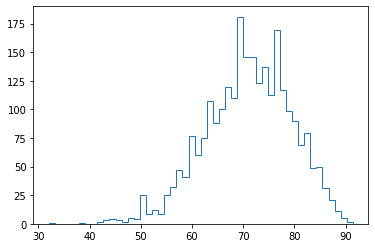

In [3]:
# 年龄
plt.hist(train_open_data["age"].to_numpy(),histtype="step",bins=50)

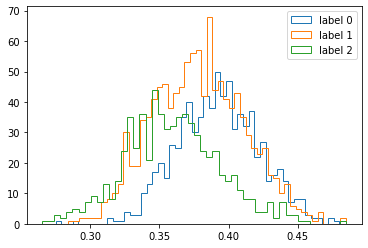

In [4]:
data = train_open_data[train_open_data["Label"] == 0]
plt.hist(data["GMV"].to_numpy()/data["TIV"].to_numpy(),histtype="step",bins=50,label="label 0")
data = train_open_data[train_open_data["Label"] == 1]
plt.hist(data["GMV"].to_numpy()/data["TIV"].to_numpy(),histtype="step",bins=50,label="label 1")
data = train_open_data[train_open_data["Label"] == 2]
plt.hist(data["GMV"].to_numpy()/data["TIV"].to_numpy(),histtype="step",bins=50,label="label 2")
plt.legend()

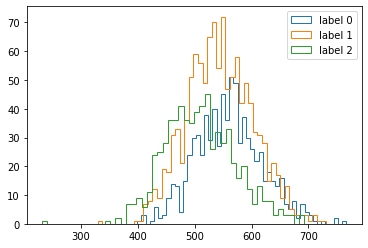

In [5]:
data = train_open_data[train_open_data["Label"] == 0]
plt.hist(data["GMV"].to_numpy(),histtype="step",bins=50,label="label 0")
data = train_open_data[train_open_data["Label"] == 1]
plt.hist(data["GMV"].to_numpy(),histtype="step",bins=50,label="label 1")
data = train_open_data[train_open_data["Label"] == 2]
plt.hist(data["GMV"].to_numpy(),histtype="step",bins=50,label="label 2")
plt.legend()

## For a feature , mean +- std.
## we can calculate the difference between AD/MCI/NC samples
## chi2 = (mean_i - mean_j)^2/(std_i^2 + std_j^2)
## we can sort these chi^2 and select the most useful features.

In [6]:
features = {
    "label0":[],
    "label1":[],
    "label2":[]
}
for i in tqdm(range(len(train_open_data))):
    file_name = os.path.join("../data/train","%s.npy"%(train_open_data["new_subject_id"][i]))
    x = np.load(file_name)
    x = np.nan_to_num(x,  nan=0, posinf=0, neginf=0)
    label = train_open_data["Label"][i]
    features["label%d"%(label)].append(x)
for key in features.keys():
    features[key] = np.array(features[key])

100%|██████████| 2600/2600 [01:54<00:00, 22.71it/s]


In [9]:
mean_features = {}
std_features = {}
for key in features.keys():
    mean_features[key] = np.mean(features[key],axis=0)
    std_features[key] = np.std(features[key],axis=0)
keys = list(features.keys())
chi2 = np.array([0 for i in mean_features["label0"]],dtype=float)
for i in range(len(keys)):
    std2 = np.power(std_features[keys[i]],2) + np.power(std_features[keys[(i + 1)%len(keys)]],2)
    if np.mean(std2) < 1.e-3:
        std2 += 1
    chi2 += np.power(mean_features[keys[i]] - mean_features[keys[(i + 1) % len(keys)]],2)/std2
chi2 = np.nan_to_num(chi2,  nan=0, posinf=0, neginf=0)
print(chi2.shape)

(28169,)


/afs/ihep.ac.cn/users/x/xuhangkun/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


In [14]:
chi2_info = {
    "dim" : np.array(range(len(chi2))),
    "chi2" :chi2
}
for i in range(3):
    chi2_info["label%d_mean"%(i)] = mean_features["label%d"%(i)]
    chi2_info["label%d_std"%(i)] = std_features["label%d"%(i)]
chi2_df = pd.DataFrame(chi2_info)
chi2_df = chi2_df.sort_values(by="chi2",ascending=False)
chi2_df = chi2_df.reset_index(drop=True)
chi2_df.to_csv("../data/chi2_info.csv",index=None)


         dim      chi2
0      13962  2.231750
1      14082  2.231750
2      14200  2.231750
3      15424  2.203995
4      14678  2.161811
...      ...       ...
28164  13884  0.000000
28165  13883  0.000000
28166  13879  0.000000
28167  13875  0.000000
28168   1511  0.000000

[28169 rows x 2 columns]


185


Text(0.5, 0, '$\\chi^{2}$')

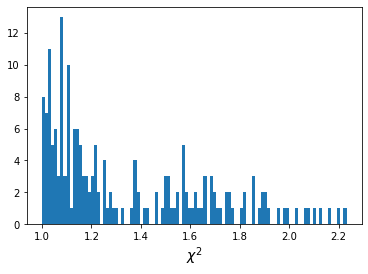

In [17]:
chi2 = set(chi2_df[chi2_df["chi2"] > 1.0]["chi2"].to_numpy())
print(len(chi2))
plt.hist(chi2,bins=100)
plt.xlabel("$\chi^{2}$",fontsize=14)